<a href="https://colab.research.google.com/github/ParkSomin23/Voice_EmotionDetection/blob/master/RNN_mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np

import os
import sys

import pandas as pd
import pickle

import time

import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from keras.utils import np_utils, to_categorical

In [ ]:
!pip install torch
#!pip install torchaudio
#!pip install GaborNet

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Base

In [8]:
class myDataset(Dataset):
    def __init__(self, d, l):
      self.d = d
      self.l = l

    def __getitem__(self, idx):
      data = self.d[idx]
      #print(data.shape)
      data = data.squeeze(2)
      data = np.transpose(data, (1,0)) #(batch, seq_len, input_size)
      l = self.l[idx].argmax()
      return data, l

    def __len__(self):
      return len(self.d)

In [ ]:
import pickle
import pandas as pd

with open("/gdrive/My Drive/mfcc_crema.pkl", 'rb') as f:
    mfcc_c = pickle.load(f)

with open("/gdrive/My Drive/mfcc_3.pkl", 'rb') as f:
    mfcc_3 = pickle.load(f)

print(mfcc_c.shape)
print(mfcc_3.shape)

ref = pd.read_csv("/gdrive/My Drive/Data_path.csv")
ref = ref.drop(11586)

mfcc = np.concatenate((mfcc_3, mfcc_c), axis=0)
mfcc.shape

(7062, 30, 216, 1)
(4524, 30, 216, 1)


(11586, 30, 216, 1)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(mfcc, ref['labels'], test_size=0.4, random_state=23)

 X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

In [ ]:
y_train[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))
#y_val = np_utils.to_categorical(lb.fit_transform(y_val))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
min = np.min(X_train, axis=0)
max = np.max(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - min) / (max - min)
X_test = (X_test - min) / (max - min)
X_val = (X_val - min) / (max - min)
#X_train = (X_train - mean)/std
#X_test = (X_test - mean)/std
#X_val = (X_val - mean)/std

In [ ]:
X_train.mean()

0.45438951368344954

In [ ]:
train_dataset = myDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)

valid_dataset = myDataset(X_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size= 16, shuffle=True)

test_dataset = myDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
print("train : ", X_train.shape)
print("valid : ", X_val.shape)
print("test : ", X_test.shape)

train :  (6951, 30, 216, 1)
valid :  (2318, 30, 216, 1)
test :  (2317, 30, 216, 1)


In [ ]:
k, l = train_dataset.__getitem__(10)
k = np.array(k)
k.shape

(216, 30)

#Network

In [14]:
#from GaborNet import GaborConv2d

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ENet(nn.Module):
    def __init__(self, n_class=14):
        super(ENet, self).__init__()
        self.n_class = n_class
        #self.gabor = GaborConv2d(in_channels=1, out_channels=12, kernel_size=(7, 7), device=device)
        self.lstm = nn.LSTM(input_size=30, hidden_size=200, num_layers=3, dropout= 0.25, batch_first=True) #(B, time, feat)

        self.fc4 = nn.Linear(200, self.n_class)

    def forward(self, x):
        x, h_n = self.lstm(x)
        
        x = self.fc4(x[:,-1,:])
        
        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model, loader, phase):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
    
  if phase == 'train':
    model.train()
    
  if phase == 'valid':
    model.eval()

  running_loss = 0.0
  running_correct = 0
  e = 1

  for i, (x, target) in enumerate(loader):
    if torch.cuda.is_available():
      x = x.cuda()
      target = target.cuda()

    if phase == 'train':
      optimizer.zero_grad()
            
    output = model(x.float())
    loss = criterion(output, target)
      
    running_loss += loss.item()

    preds = output.argmax(dim=1)
    running_correct += (preds == target).sum()
      
    if phase == 'train':
      loss.backward()
      optimizer.step()

    e += 1

  loss = running_loss / e #float(len(loader.dataset))
  acc = 100. * running_correct / float(len(loader.dataset))
    
  return  loss, acc

In [ ]:
net = ENet()
if torch.cuda.is_available():
  net = net.cuda()

train_loss, train_acc = [], []
val_loss, val_acc = [], []
best_acc = 0.0

for epoch in range(100):
  t_loss, t_acc = fit(net, train_loader, 'train')
  v_loss, v_acc = fit(net, valid_loader, 'valid')

  if v_acc > best_acc:
    best_acc = v_acc
    best_model = net.state_dict()

  train_loss.append(t_loss)
  train_acc.append(t_acc)
  val_loss.append(v_loss)
  val_acc.append(v_acc)

tensor(62.5108, device='cuda:0')


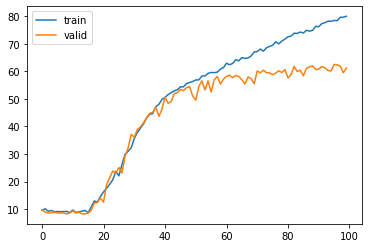

In [ ]:
plt.plot(range(len(train_acc)), train_acc, label='train')
plt.plot(range(len(val_acc)), val_acc, label='valid')
plt.legend()
print(best_acc)

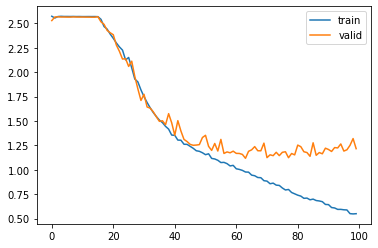

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(val_loss)), val_loss, label='valid')
plt.legend()

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
correct = 0

test_net = ENet()
test_net.load_state_dict(best_model)
cm = np.zeros((14,14))
c = np.arange(14)

for i, (x, target) in enumerate(test_loader):
  if torch.cuda.is_available():
    x = x.cuda()
    target = target.cuda()
    test_net = test_net.cuda()

  output = test_net(x.float())
  preds = output.argmax(dim=1)

  correct += (preds == target).sum()
  cm += confusion_matrix(preds.cpu(), target.cpu(), labels = c)

acc = 100. * correct / len(test_loader.dataset)

print("ACC Test")
print(acc)

ACC Test
tensor(60.3798, device='cuda:0')


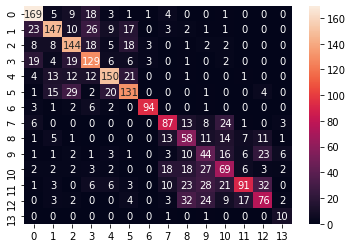

In [ ]:
import seaborn as sns

cm_d = cm.astype('int')
l = ['f_angry' 'f_disgust' 'f_fear' 'f_happy'
 'f_neutral' 'f_sad' 'f_surprise' 'm_angry'
 'm_disgust' 'm_fear' 'm_happy' 'm_neutral' 'm_sad'
 'm_surprise'] #lb.classes_
sns.heatmap(cm_d, annot=True, fmt='d') #, xticklabels=l) #, yticklabels=l)

# Separate Gender - MFCC

In [5]:
import pickle
import pandas as pd

with open("/gdrive/My Drive/female_mfcc.pkl", 'rb') as f:
    female_ref = pickle.load(f)

with open("/gdrive/My Drive/male_mfcc.pkl", 'rb') as f:
    male_ref = pickle.load(f)

print(female_ref.shape)
print(male_ref.shape)

female_path = pd.read_csv("/gdrive/My Drive/dataset_female.csv")
male_path = pd.read_csv("/gdrive/My Drive/dataset_male.csv")
male_path = male_path.drop(4717)
male_path

(6869, 30, 216, 1)
(4717, 30, 216, 1)


,Unnamed: 0,labels,source,path
0,0,male_neutral,SAVEE,/gdrive/My Drive/SAVEE/DC_n11.wav
1,1,male_angry,SAVEE,/gdrive/My Drive/SAVEE/DC_a12.wav
2,2,male_fear,SAVEE,/gdrive/My Drive/SAVEE/JE_f04.wav
3,3,male_disgust,SAVEE,/gdrive/My Drive/SAVEE/JK_d15.wav
4,4,male_happy,SAVEE,/gdrive/My Drive/SAVEE/DC_h14.wav
...,...,...,...,...
4712,11581,male_fear,CREMA,/gdrive/My Drive/CREMA-D/1087_IOM_FEA_XX.wav
4713,11582,male_happy,CREMA,/gdrive/My Drive/CREMA-D/1087_IOM_HAP_XX.wav
4714,11583,male_neutral,CREMA,/gdrive/My Drive/CREMA-D/1087_IOM_NEU_XX.wav
4715,11584,male_sad,CREMA,/gdrive/My Drive/CREMA-D/1087_IOM_SAD_XX.wav


In [26]:
#female
f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(female_ref, female_path['labels'], test_size=0.4, random_state=23)

f_X_test, f_X_val, f_y_test, f_y_val = train_test_split(f_X_test, f_y_test, test_size=0.5, random_state=23)

# one hot encode the target 
f_lb = LabelEncoder()
f_y_train = np_utils.to_categorical(f_lb.fit_transform(f_y_train))
f_y_test = np_utils.to_categorical(f_lb.fit_transform(f_y_test))
f_y_val = np_utils.to_categorical(f_lb.fit_transform(f_y_val))

fmin = np.min(f_X_train, axis=0)
fmax = np.max(f_X_train, axis=0)

X_train = (f_X_train - fmin) / (fmax - fmin)
X_test = (f_X_test - fmin) / (fmax - fmin)
X_val = (f_X_val - fmin) / (fmax - fmin)


##male
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(male_ref, male_path['labels'], test_size=0.4, random_state=23)
m_X_test, m_X_val, m_y_test, m_y_val = train_test_split(m_X_test, m_y_test, test_size=0.5, random_state=23)

lb = LabelEncoder()
m_y_train = np_utils.to_categorical(lb.fit_transform(m_y_train))
m_y_test = np_utils.to_categorical(lb.fit_transform(m_y_test))
m_y_val = np_utils.to_categorical(lb.fit_transform(m_y_val))

mmin = np.min(m_X_train, axis=0)
mmax = np.max(m_X_train, axis=0)

m_X_train = (m_X_train - mmin)/ (mmax - mmin)
m_X_test = (m_X_test - mmin)/ (mmax - mmin)
m_X_val = (m_X_val - mmin)/ (mmax - mmin)

In [28]:
f_lb.classes_

array(['female_angry', 'female_disgust', 'female_fear', 'female_happy',
       'female_neutral', 'female_sad', 'female_surprise'], dtype=object)

**female**

In [11]:
female_train_dataset = myDataset(f_X_train, f_y_train)
female_train_loader = DataLoader(female_train_dataset, batch_size= 16, shuffle=True)

female_valid_dataset = myDataset(f_X_val, f_y_val)
female_valid_loader = DataLoader(female_valid_dataset, batch_size= 16, shuffle=True)

female_test_dataset = myDataset(f_X_test, f_y_test)
female_test_loader = DataLoader(female_test_dataset, batch_size=32, shuffle=True)

In [12]:
print("train : ", f_X_train.shape)
print("valid : ", f_X_val.shape)
print("test : ", f_X_test.shape)

train :  (4121, 30, 216, 1)
valid :  (1374, 30, 216, 1)
test :  (1374, 30, 216, 1)


In [15]:
female_mfcc_model = ENet(7)
if torch.cuda.is_available():
  female_mfcc_model = female_mfcc_model.cuda()

train_loss, train_acc = [], []
val_loss, val_acc = [], []
best_acc = 0.0

for epoch in range(100):
  t_loss, t_acc = fit(female_mfcc_model, female_train_loader, 'train')
  v_loss, v_acc = fit(female_mfcc_model, female_valid_loader, 'valid')

  if v_acc > best_acc:
    best_acc = v_acc
    best_model_f_mfcc = female_mfcc_model.state_dict()

  train_loss.append(t_loss)
  train_acc.append(t_acc)
  val_loss.append(v_loss)
  val_acc.append(v_acc)

tensor(76.1281, device='cuda:0')


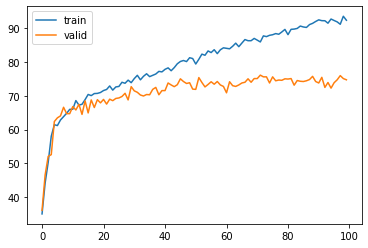

In [16]:
print(best_acc)

plt.plot(range(len(train_acc)), train_acc, label='train')
plt.plot(range(len(val_acc)), val_acc, label='valid')
plt.legend()

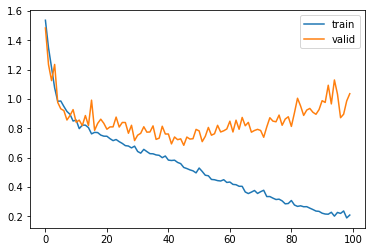

In [17]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(val_loss)), val_loss, label='valid')
plt.legend()

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
correct = 0

test_net = ENet(7)
test_net.load_state_dict(best_model_f_mfcc)
cm = np.zeros((7,7))
c = np.arange(7)

for i, (x, target) in enumerate(female_test_loader):
  if torch.cuda.is_available():
    x = x.cuda()
    target = target.cuda()
    test_net = test_net.cuda()

  output = test_net(x.float())
  preds = output.argmax(dim=1)

  correct += (preds == target).sum()
  cm += confusion_matrix(preds.cpu(), target.cpu(), labels = c)

acc = 100. * correct / float(len(female_test_loader.dataset))

print("ACC Test")
print(acc)

ACC Test
tensor(75.7642, device='cuda:0')


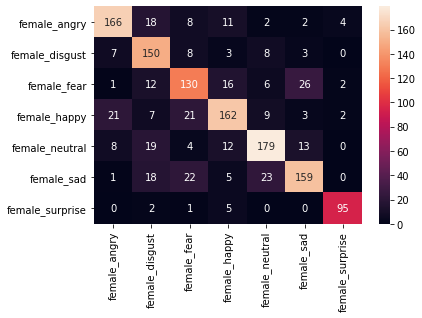

In [29]:
import seaborn as sns
cm_d = cm.astype('int')
l = f_lb.classes_
sns.heatmap(cm_d, annot=True, fmt='d', xticklabels=l, yticklabels=l)
#print(l)

In [23]:
with open('frnn__mfcc_30_100.pkl', 'wb') as f:
  pickle.dump(best_model_f_mfcc, f)

**male**

In [30]:
male_train_dataset = myDataset(m_X_train, m_y_train)
male_train_loader = DataLoader(male_train_dataset, batch_size= 16, shuffle=True)

male_valid_dataset = myDataset(m_X_val, m_y_val)
male_valid_loader = DataLoader(male_valid_dataset, batch_size= 16, shuffle=True)

male_test_dataset = myDataset(m_X_test, m_y_test)
male_test_loader = DataLoader(male_test_dataset, batch_size=32, shuffle=True)

In [31]:
print("train : ", m_X_train.shape)
print("valid : ", m_X_val.shape)
print("test : ", m_X_test.shape)

train :  (2830, 30, 216, 1)
valid :  (944, 30, 216, 1)
test :  (943, 30, 216, 1)


In [ ]:
male_mfcc_model = ENet(7)
if torch.cuda.is_available():
  male_mfcc_model = male_mfcc_model.cuda()

train_loss, train_acc = [], []
val_loss, val_acc = [], []
best_acc = 0.0

for epoch in range(700):
  t_loss, t_acc = fit(male_mfcc_model, male_train_loader, 'train')
  v_loss, v_acc = fit(male_mfcc_model, male_valid_loader, 'valid')

  if v_acc > best_acc:
    best_acc = v_acc
    best_model_m_mfcc = male_mfcc_model.state_dict()

  train_loss.append(t_loss)
  train_acc.append(t_acc)
  val_loss.append(v_loss)
  val_acc.append(v_acc)

tensor(45.9746, device='cuda:0')


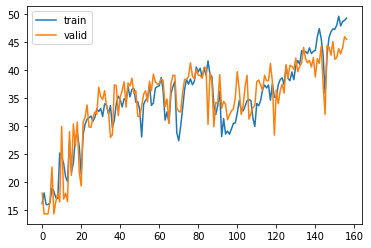

In [33]:
print(best_acc)

plt.plot(range(len(train_acc)), train_acc, label='train')
plt.plot(range(len(val_acc)), val_acc, label='valid')
plt.legend()

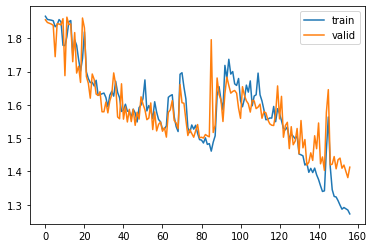

In [34]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(val_loss)), val_loss, label='valid')
plt.legend()

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
correct = 0

test_net = ENet(7)
test_net.load_state_dict(best_model_m_mfcc)
cm = np.zeros((7,7))
c = np.arange(7)

for i, (x, target) in enumerate(male_test_loader):
  if torch.cuda.is_available():
    x = x.cuda()
    target = target.cuda()
    test_net = test_net.cuda()

  output = test_net(x.float())
  preds = output.argmax(dim=1)

  correct += (preds == target).sum()
  cm += confusion_matrix(preds.cpu(), target.cpu(), labels = c)

acc = 100. * correct / float(len(male_test_loader.dataset))

print("ACC Test")
print(acc)

ACC Test
tensor(44.4327, device='cuda:0')


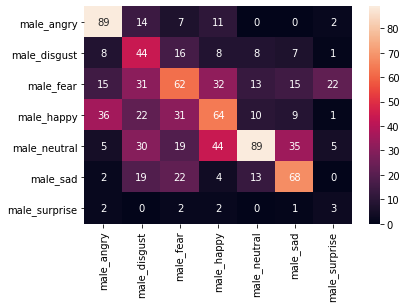

In [38]:
import seaborn as sns
cm_d = cm.astype('int')
l = lb.classes_
sns.heatmap(cm_d, annot=True, fmt='d', xticklabels=l, yticklabels=l)

In [39]:
with open('mrnn_mfcc_30_100.pkl', 'wb') as f:
  pickle.dump(best_model_m_mfcc, f)